In [1]:
import os
import sys

# Add project root to Python path FIRST
sys.path.append(os.path.abspath(os.path.join("..")))

# Now imports will work
from src.config import SEED, FIG_DIR
from src.data import load_dataset
from src.preprocess import build_preprocess_pipeline, make_train_test_split
from src.models import make_logistic_regression, make_random_forest
from src.evaluation import evaluate_classifier, roc_curve_data, cross_validate_model
from src.viz import plot_roc_curves

import pandas as pd
import matplotlib.pyplot as plt


In [2]:
X, y, feature_names = load_dataset()
print("X:", X.shape, "y:", y.shape)
print("Class balance:", y.value_counts().to_dict())
X.head()


X: (303, 13) y: (303,)
Class balance: {1: 165, 0: 138}


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0


In [3]:
X_train, X_test, y_train, y_test = make_train_test_split(X, y)

preprocess = build_preprocess_pipeline(X_train)
X_train_p = preprocess.fit_transform(X_train)
X_test_p  = preprocess.transform(X_test)

print("Processed shapes:", X_train_p.shape, X_test_p.shape)


Processed shapes: (242, 13) (61, 13)


In [4]:
lr = make_logistic_regression(SEED)
rf = make_random_forest(SEED)

lr.fit(X_train_p, y_train)
rf.fit(X_train_p, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
lr_metrics = evaluate_classifier(lr, X_test_p, y_test, "Logistic Regression")
rf_metrics = evaluate_classifier(rf, X_test_p, y_test, "Random Forest")

pd.DataFrame([lr_metrics, rf_metrics])


,model,accuracy,auc
0,Logistic Regression,0.803279,0.869048
1,Random Forest,0.819672,0.906385


In [6]:
lr_cv = cross_validate_model(lr, X_train_p, y_train, cv=5)
rf_cv = cross_validate_model(rf, X_train_p, y_train, cv=5)

pd.DataFrame([
    {"Model": "LR", "CV Mean": lr_cv["cv_mean_accuracy"], "CV Std": lr_cv["cv_std_accuracy"]},
    {"Model": "RF", "CV Mean": rf_cv["cv_mean_accuracy"], "CV Std": rf_cv["cv_std_accuracy"]},
])


,Model,CV Mean,CV Std
0,LR,0.830867,0.040931
1,RF,0.830782,0.043518


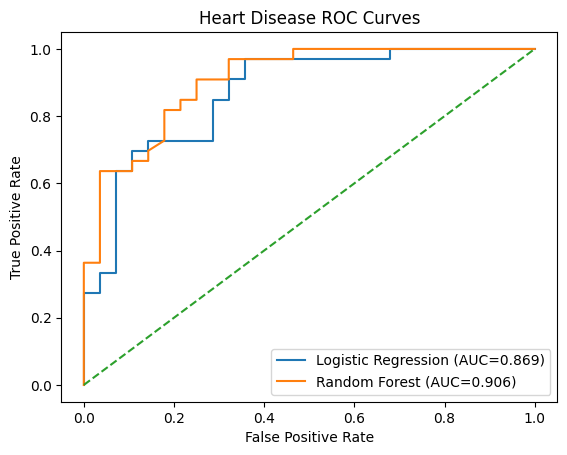

In [7]:
lr_roc = roc_curve_data(lr, X_test_p, y_test, "Logistic Regression")
rf_roc = roc_curve_data(rf, X_test_p, y_test, "Random Forest")

os.makedirs(FIG_DIR, exist_ok=True)
plot_roc_curves([lr_roc, rf_roc], title="Heart Disease ROC Curves")
plt.show()
